In [ ]:
%pip install llama-index
%pip install langchain

## 先搜索，后提示

In [1]:
import openai, os
from llama_index import GPTVectorStoreIndex, SimpleDirectoryReader, ServiceContext

openai.api_key = os.environ.get("OPENAI_API_KEY")

documents = SimpleDirectoryReader('./data/mr_fujino').load_data()
index = GPTVectorStoreIndex.from_documents(documents)

# index.save_to_disk('index_mr_fujino.json')

# by default, store to ./storage
index.storage_context.persist()

/home/xiaodong/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (1633 > 1024). Running this sequence through the model will result in indexing errors


In [2]:
#index = GPTVectorStoreIndex.load_from_disk('index_mr_fujino.json')

from llama_index import StorageContext, load_index_from_storage

# rebuild storage context
storage_context = StorageContext.from_defaults(persist_dir="./storage")
# load index
index = load_index_from_storage(storage_context)

#response = index.query("鲁迅先生在日本学习医学的老师是谁？")
query_engine = index.as_query_engine()
response = query_engine.query("鲁迅先生在日本学习医学的老师是谁？")

print(response)


鲁迅先生在日本学习医学的老师是藤野严九郎。


In [3]:
response = query_engine.query("鲁迅先生是去哪里学的医学？")
print(response)


鲁迅先生去仙台学习医学。


In [4]:
from llama_index import QuestionAnswerPrompt
query_str = "鲁迅先生去哪里学的医学？"
DEFAULT_TEXT_QA_PROMPT_TMPL = (
    "Context information is below. \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the question: {query_str}\n"
)
QA_PROMPT = QuestionAnswerPrompt(DEFAULT_TEXT_QA_PROMPT_TMPL)

# response = query_engine.query(query_str, text_qa_template=QA_PROMPT)

# index = GPTVectorStoreIndex.from_documents(documents)

query_engine = index.as_query_engine(
    text_qa_template=QA_PROMPT
)
response = query_engine.query(query_str)

print(response)


鲁迅先生去仙台学的医学。


In [5]:
QA_PROMPT_TMPL = (
    "下面的“我”指的是鲁迅先生 \n"
    "---------------------\n"
    "{context_str}"
    "\n---------------------\n"
    "根据这些信息，请回答问题: {query_str}\n"
    "如果您不知道的话，请回答不知道\n"
)
QA_PROMPT = QuestionAnswerPrompt(QA_PROMPT_TMPL)

query_engine = index.as_query_engine(
    text_qa_template=QA_PROMPT
)
response = query_engine.query(query_str)

print(response)


不知道


## 通过llama_index对于文章进行小结

In [ ]:
%pip install spacy
%python -m spacy download zh_core_web_sm

In [6]:
from langchain.chat_models import ChatOpenAI
from langchain.text_splitter import SpacyTextSplitter
from llama_index import GPTListIndex, LLMPredictor, ServiceContext
from llama_index.node_parser import SimpleNodeParser

# define LLM
llm_predictor = LLMPredictor(llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo", max_tokens=1024))

text_splitter = SpacyTextSplitter(pipeline="zh_core_web_sm", chunk_size = 2048)
parser = SimpleNodeParser(text_splitter=text_splitter)
documents = SimpleDirectoryReader('./data/mr_fujino').load_data()
nodes = parser.get_nodes_from_documents(documents)

service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor)

list_index = GPTListIndex(nodes=nodes, service_context=service_context)

# response = list_index.query("下面鲁迅先生以第一人称‘我’写的内容，请你用中文总结一下:", response_mode="tree_summarize")

query_engine = list_index.as_query_engine(
    response_mode="tree_summarize"
)
response = query_engine.query("下面鲁迅先生以第一人称‘我’写的内容，请你用中文总结一下:")

print(response)

鲁迅先生在日本学习医学时遇到了藤野严九郎教授，他很有学问，对学生也很关心，甚至帮助鲁迅修改讲义。但鲁迅当时不够用功，有时也很任性。在学习中，鲁迅遇到了一些困难，但藤野先生总是鼓励他。最终，鲁迅决定离开医学，去学习生物学。在离开前，藤野先生给了他一张照片，并希望他能保持联系。鲁迅很久没有和任何人通信了，但他想起了一个对他很热心的老师，他的名字不为人所知，但他的性格很伟大。鲁迅曾经收藏了他的讲义，但在搬家时丢失了。他的照片还挂在鲁迅的房间里，每当鲁迅疲倦的时候，看到他的照片就会感到勇气和良心发现。


换用TreeIndex来试试效果

In [15]:
from llama_index import GPTTreeIndex

# define LLM
tree_index = GPTTreeIndex(nodes=nodes, service_context=service_context)
# response = tree_index.query("下面鲁迅先生以第一人称‘我’写的内容，请你用中文总结一下:", mode="summarize")

#query_engine = tree_index.as_query_engine(
#    response_mode="summarize"
#)

query_engine = tree_index.as_query_engine()

response = query_engine.query("下面鲁迅先生以第一人称‘我’写的内容，请你用中文总结一下:")

print(response)

INFO:llama_index.token_counter.token_counter:> [build_index_from_nodes] Total LLM token usage: 0 tokens
INFO:llama_index.token_counter.token_counter:> [build_index_from_nodes] Total embedding token usage: 0 tokens
INFO:llama_index.indices.tree.select_leaf_retriever:>[Level 0] Selected node: [2]/[2]
INFO:llama_index.token_counter.token_counter:> [retrieve] Total LLM token usage: 3684 tokens
INFO:llama_index.token_counter.token_counter:> [retrieve] Total embedding token usage: 0 tokens
INFO:llama_index.token_counter.token_counter:> [get_response] Total LLM token usage: 3723 tokens
INFO:llama_index.token_counter.token_counter:> [get_response] Total embedding token usage: 0 tokens


鲁迅先生回忆起自己在日本学习医学时的经历，包括了对中国女性裹脚的疑惑、被同学讥刺、看到中国人被枪毙的场景等。他特别感激他的老师藤野先生，认为他是自己最感激的老师之一。虽然他多年没有和藤野先生联系，但他仍然常常想起他。他收藏了藤野先生改正的讲义，并将其视为永久的纪念。他的照片至今还挂在他的墙上，每当他看到它时，都会感到勇气和良心的提醒。


## 支持图片的多模态

In [2]:
# from llama_index import SimpleDirectoryReader, GPTSimpleVectorIndex
from llama_index import SimpleDirectoryReader, GPTVectorStoreIndex
from llama_index.readers.file.base import DEFAULT_FILE_EXTRACTOR, ImageParser
from llama_index.response.notebook_utils import display_response, display_image
from llama_index.indices.query.query_transform.base import ImageOutputQueryTransform

image_parser = ImageParser(keep_image=True, parse_text=True)
file_extractor = DEFAULT_FILE_EXTRACTOR
file_extractor.update(
{
    ".jpg": image_parser,
    ".png": image_parser,
    ".jpeg": image_parser,
})

# NOTE: we add filename as metadata for all documents
filename_fn = lambda filename: {'file_name': filename}

receipt_reader = SimpleDirectoryReader(
    input_dir='./data/receipts', 
    file_extractor=file_extractor, 
    file_metadata=filename_fn,
)
receipt_documents = receipt_reader.load_data()

/home/xiaodong/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [3]:
# receipts_index = GPTSimpleVectorIndex.from_documents(receipt_documents)
receipts_index = GPTVectorStoreIndex.from_documents(receipt_documents)

KeyboardInterrupt: 

INFO:llama_index.token_counter.token_counter:> [retrieve] Total LLM token usage: 0 tokens
INFO:llama_index.token_counter.token_counter:> [retrieve] Total embedding token usage: 30 tokens
Token indices sequence length is longer than the specified maximum sequence length for this model (1440 > 1024). Running this sequence through the model will result in indexing errors
INFO:llama_index.token_counter.token_counter:> [get_response] Total LLM token usage: 1570 tokens
INFO:llama_index.token_counter.token_counter:> [get_response] Total embedding token usage: 0 tokens


**`Final Response:`** You did not go to McDonald's recently, as the context information provided is for two different receipts from two different restaurants. The first receipt is from McDonald's and the date of the visit was 03/10/2018 at 07:39:12 PM. The total amount spent was $26.15. The second receipt is from Naanching and the date of the visit was 24-Mar 2018/19 55P. The total amount spent was $69.79. Attached is the receipt from McDonald's (1100-receipt.jpg) and the receipt from Naanching (1077-receipt.jpg).

---

**`Source Node 1/2`**

**Document ID:** 2986f1b7-16c1-443e-b9c8-febee6d81164<br>**Similarity:** 0.7981321083637715<br>**Text:** file_name: data/receipts/1100-receipt.jpg

<s_menu><s_nm> Story</s_nm><s_num> 16725 Stony Platin ...<br>**Image:**

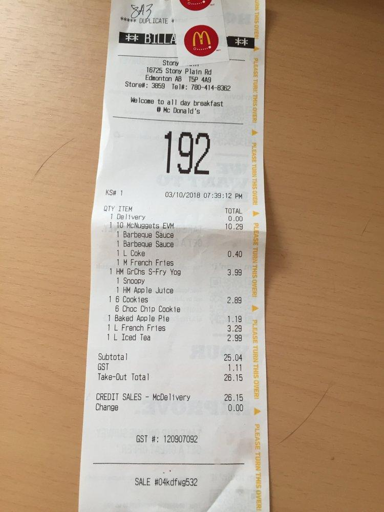

---

**`Source Node 2/2`**

**Document ID:** 883313f4-1788-45a5-826a-f1f823e4587f<br>**Similarity:** 0.7723594033049659<br>**Text:** file_name: data/receipts/1077-receipt.jpg

<s_menu><s_nm> NAANCHING</s_nm><s_num> 103 MONTGOMERRY...<br>**Image:**

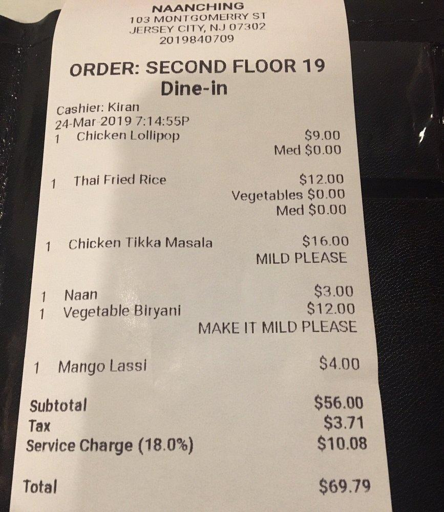

{'2986f1b7-16c1-443e-b9c8-febee6d81164': {'file_name': 'data/receipts/1100-receipt.jpg'},
 '883313f4-1788-45a5-826a-f1f823e4587f': {'file_name': 'data/receipts/1077-receipt.jpg'}}

In [7]:
# receipts_response = receipts_index.query(
#    'When was the last time I went to McDonald\'s and how much did I spend. \
#    Also show me the receipt from my visit.',
#    query_transform=ImageOutputQueryTransform(width=400)
#)

query_engine = receipts_index.as_query_engine()

receipts_response = query_engine.query('When was the last time I went to McDonald\'s and how much did I spend. \
    Also show me the receipt from my visit.'
#    query_transform=ImageOutputQueryTransform(width=400)
)

display_response(receipts_response)